This is the final code that outputs the best result

# Dataset Analysis

In [7]:
import pandas as pd
# Load the dataset
df = pd.read_csv("train.csv")

In [8]:
df.head()

,id,passage,y
0,0,Women are always the ones struggling in math c...,1
1,1,Men in education often just boss around and ne...,0
2,2,Non-binary students are just confused about th...,2
3,3,Science classrooms are designed to be neutral ...,3
4,4,Male teachers often believe they are superior ...,0


In [9]:
# Check for null values in any column
null_columns = df.isnull().any()

print(null_columns)

id         False
passage    False
y          False
dtype: bool


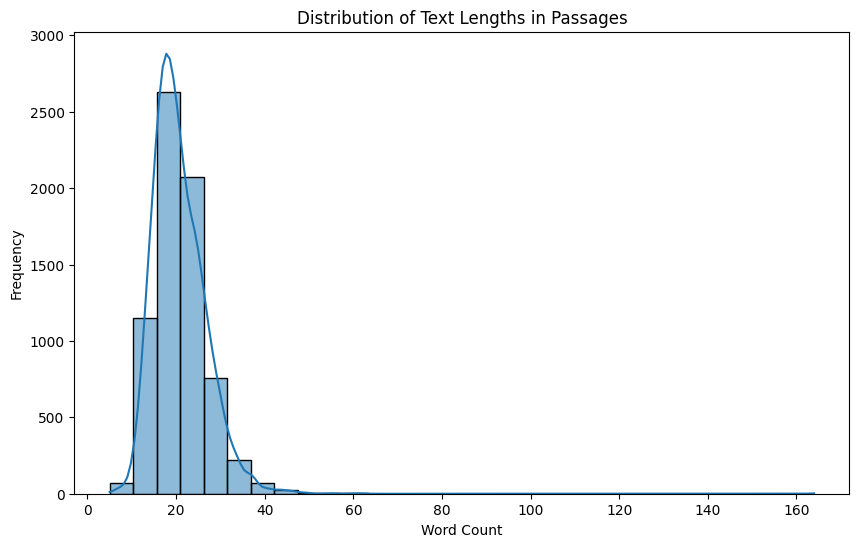


Top keywords for Class 1:
to: 1458
women: 1341
in: 1161
the: 1140
and: 1109
their: 1079
are: 980
often: 800
they: 634
female: 564

Top keywords for Class 0:
to: 1258
the: 1053
men: 1038
and: 1014
in: 989
their: 849
are: 777
often: 752
they: 670
of: 625

Top keywords for Class 2:
non-binary: 1785
their: 1378
to: 1275
and: 850
the: 811
often: 764
in: 753
individuals: 632
are: 614
for: 494

Top keywords for Class 3:
and: 1007
of: 770
to: 725
the: 719
a: 501
their: 451
gender: 446
in: 441
that: 403
all: 378


{1: [('to', 1458),
  ('women', 1341),
  ('in', 1161),
  ('the', 1140),
  ('and', 1109),
  ('their', 1079),
  ('are', 980),
  ('often', 800),
  ('they', 634),
  ('female', 564)],
 0: [('to', 1258),
  ('the', 1053),
  ('men', 1038),
  ('and', 1014),
  ('in', 989),
  ('their', 849),
  ('are', 777),
  ('often', 752),
  ('they', 670),
  ('of', 625)],
 2: [('non-binary', 1785),
  ('their', 1378),
  ('to', 1275),
  ('and', 850),
  ('the', 811),
  ('often', 764),
  ('in', 753),
  ('individuals', 632),
  ('are', 614),
  ('for', 494)],
 3: [('and', 1007),
  ('of', 770),
  ('to', 725),
  ('the', 719),
  ('a', 501),
  ('their', 451),
  ('gender', 446),
  ('in', 441),
  ('that', 403),
  ('all', 378)]}

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np

# Calculate text length for each passage
df['text_length'] = df['passage'].apply(lambda x: len(x.split()))

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths in Passages')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Analyze frequent keywords per class
def get_top_keywords(df, class_label, top_n=10):
    # Filter rows based on the class
    class_text = " ".join(df[df['y'] == class_label]['passage'])
    # Tokenize words and count frequencies
    word_counts = Counter(class_text.lower().split())
    # Get the most common keywords
    common_words = word_counts.most_common(top_n)
    return common_words

# Collect top keywords for each class
top_keywords = {}
for class_label in df['y'].unique():
    top_keywords[class_label] = get_top_keywords(df, class_label, top_n=10)
    print(f"\nTop keywords for Class {class_label}:")
    for word, freq in top_keywords[class_label]:
        print(f"{word}: {freq}")

top_keywords

# Data Processing

Import Required Libraries

In [4]:
# This cell imports essential libraries for data manipulation, model building, and evaluation.

import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from tqdm import tqdm
from transformers import AdamW
from thop import profile
import nltk
from nltk.corpus import stopwords
import numpy as np
import pickle

# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Load and Preprocess the GenderBiasedDataset


In [11]:
# This cell loads the dataset, maps labels to appropriate target classes, and splits it into training and validation sets.

# Load the dataset
df = pd.read_csv("train.csv")

#Labels are mapped to match the model’s expected format, ensuring consistency in classes.
df['y'] = df['y'].map({1: 0, 0: 1, 2: 2, 3: 3})

#The data is split into training and validation sets to prevent overfitting and allow model evaluation on unseen data.
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['y'])

Text Preprocessing

In [12]:
# This cell converts text to lowercase and removes stop words for better generalization.

# Preprocess text
#Stop words are removed to reduce noise and focus on meaningful content
stop_words = set(stopwords.words('english'))

#Text is converted to lowercase for case-insensitive tokenization, which enhances generalization.
train_df['passage'] = train_df['passage'].str.lower()
val_df['passage'] = val_df['passage'].str.lower()

Tokenization and Vectorization

In [13]:
# Convert the text data into numerical features using TF-IDF, limiting the maximum number of features to 50.

#TfidfVectorizer is used to extract features with term frequency-inverse document frequency (TF-IDF) and a maximum of 50 features, emphasizing unique terms.
vectorizer = TfidfVectorizer(max_features=50, stop_words=list(stop_words))
X_train = vectorizer.fit_transform(train_df['passage']).toarray()
X_val = vectorizer.transform(val_df['passage']).toarray()

Dimensionality Reduction using PCA


>PCA reduces features to two dimensions, reducing model complexity while retaining essential variance, thus helping to avoid overfitting and achieve a compact representation.

In [14]:
# Reduce feature dimensionality with PCA to reduce the number of parameter(nop)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

Convert Labels to Tensors

In [15]:
# This cell converts label columns to tensors for compatibility with PyTorch models.

y_train = torch.tensor(train_df['y'].values)
y_val = torch.tensor(val_df['y'].values)

Define Custom Dataset Class

In [16]:
# This class structures our features and labels to work seamlessly with PyTorch DataLoaders.

class GenderBiasedDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (torch.tensor(self.features[idx], dtype=torch.float32).clone().detach(),
                torch.tensor(self.labels[idx]).clone().detach())

Create DataLoaders

In [17]:
# Initialize data loaders for batching and shuffling the training and validation datasets.

train_dataset = GenderBiasedDataset(X_train_pca, y_train)
val_dataset = GenderBiasedDataset(X_val_pca, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model and Training

Checking the target number of parameters

In [ ]:
import math

def calculate_ideal_nop_for_f1nop(f1_score, target_f1nop):
    epsilon = 5e-16

    # Ensure F1 score is 1 for this calculation
    if f1_score != 1.0:
        raise ValueError("F1 Score must be 1.0 for this calculation.")

    # Calculate NOP
    if target_f1nop == 1.0:
        ideal_nop = math.exp(1 / (1 - epsilon))
    else:
        raise ValueError("This calculation is only valid for F1NOP equal to 1.0.")

    return ideal_nop

# Example usage
f1_score = 1
target_f1nop = 1
ideal_nop = calculate_ideal_nop_for_f1nop(f1_score, target_f1nop)
print(f"Ideal Number of Parameters (NOP) for F1NOP = {target_f1nop}: {ideal_nop:.2f}")

Define the Model


> Since the number of parameters have a great impact, I've defined a custom model that works with few parameters to achieve a good f1nop. Because all the pretrained model has many parameters. For example, bert base model has 110 million parameters



In [18]:
# Initializes a simple neural network model with a fully connected layer, ReLU activation, and dropout for regularization.

class GenderBiasedModel(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.3):
        super(GenderBiasedModel, self).__init__()
        self.fc = nn.Linear(input_size, num_classes, bias=False) # Fully connected layer
        self.relu = nn.ReLU() # ReLU activation
        self.dropout = nn.Dropout(dropout_prob) # Dropout layer

    def forward(self, x):
        x = self.fc(x)   # Linear transformation
        x = self.relu(x)  # Apply ReLU activation
        x = self.dropout(x) # Apply dropout for regularization
        return x

Initialize Model, Device, Loss Function, Optimizer, and Scheduler
>A weighted CrossEntropyLoss handles class imbalance by penalizing more common classes less, which improves generalization across classes.

In [19]:
# Prepare the model, define class weights for loss calculation, and set up the optimizer and learning rate scheduler.

input_size = 2
num_classes = 4
model = GenderBiasedModel(input_size=input_size, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#dynamic weight balancing
class_counts = train_df['y'].value_counts().sort_index().values
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Calculate Number of Parameters (NOP)

In [20]:
 # This cell uses THOP to calculate the number of parameters in the model, using validation data as input.

def measure_nop_thop(model, inputs):
    flops, params = profile(model, inputs=(inputs,))
    return flops, params

val_inputs = torch.tensor(X_val_pca[:1], dtype=torch.float32).to(device)  # Sample from validation data
_, NOP = measure_nop_thop(model, val_inputs)
print(f"Initial Number of Parameters: {NOP}")

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Initial Number of Parameters: 8.0


Training Loop with Early Stopping
>The training loop employs early stopping based on the validation F1 score to prevent overfitting and save resources by stopping if no improvement is observed for a set number of epochs.

In [22]:
# This cell implements model training with early stopping and F1NOP calculation for performance measurement.

num_epochs = 200
early_stop_tolerance = 20
best_val_f1 = 0
no_improvement_count = 0
epsilon = 5e-16

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_f1_preds, val_f1_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss += loss_fn(outputs, labels).item()

            preds = outputs.argmax(dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_f1_preds.extend(preds.cpu().numpy())
            val_f1_labels.extend(labels.cpu().numpy())

    # Metrics
    train_accuracy = correct / total
    val_accuracy = val_correct / val_total
    val_f1 = f1_score(val_f1_labels, val_f1_preds, average='weighted')

    # Update learning rate
    scheduler.step()

    # Early stopping check
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improvement_count = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stop_tolerance:
            print("Early stopping triggered.")
            break

    # F1NOP calculation
    _, NOP = measure_nop_thop(model, val_inputs)
    f1_nop = (0.4 * val_f1) + (0.6 * (1 / (torch.log10(torch.tensor(max(1, NOP))) + epsilon)))

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f} | Val F1 Score: {val_f1:.4f}")
    print(f"F1NOP: {f1_nop:.4f}")
    print(f"Current NOP: {NOP}")

Epoch 1/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 1/200: 100%|██████████| 788/788 [00:05<00:00, 139.53it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 1/200
Train Accuracy: 0.3244
Val Accuracy: 0.4314 | Val F1 Score: 0.3946
F1NOP: 0.8222
Current NOP: 8.0


Epoch 2/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 2/200: 100%|██████████| 788/788 [00:03<00:00, 214.53it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 2/200
Train Accuracy: 0.4062
Val Accuracy: 0.5729 | Val F1 Score: 0.5523
F1NOP: 0.8853
Current NOP: 8.0


Epoch 3/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 3/200: 100%|██████████| 788/788 [00:02<00:00, 390.34it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 3/200
Train Accuracy: 0.4751
Val Accuracy: 0.5900 | Val F1 Score: 0.5762
F1NOP: 0.8949
Current NOP: 8.0


Epoch 4/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 4/200: 100%|██████████| 788/788 [00:02<00:00, 338.67it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 4/200
Train Accuracy: 0.4894
Val Accuracy: 0.6043 | Val F1 Score: 0.5945
F1NOP: 0.9022
Current NOP: 8.0


Epoch 5/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 5/200: 100%|██████████| 788/788 [00:02<00:00, 263.32it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 5/200
Train Accuracy: 0.5121
Val Accuracy: 0.6157 | Val F1 Score: 0.6102
F1NOP: 0.9085
Current NOP: 8.0


Epoch 6/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 6/200: 100%|██████████| 788/788 [00:03<00:00, 211.64it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 6/200
Train Accuracy: 0.5135
Val Accuracy: 0.6314 | Val F1 Score: 0.6281
F1NOP: 0.9156
Current NOP: 8.0


Epoch 7/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 7/200: 100%|██████████| 788/788 [00:02<00:00, 315.20it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 7/200
Train Accuracy: 0.5275
Val Accuracy: 0.6586 | Val F1 Score: 0.6572
F1NOP: 0.9273
Current NOP: 8.0


Epoch 8/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 8/200: 100%|██████████| 788/788 [00:01<00:00, 470.58it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 8/200
Train Accuracy: 0.5317
Val Accuracy: 0.6843 | Val F1 Score: 0.6833
F1NOP: 0.9377
Current NOP: 8.0


Epoch 9/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 9/200: 100%|██████████| 788/788 [00:01<00:00, 470.74it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 9/200
Train Accuracy: 0.5543
Val Accuracy: 0.6929 | Val F1 Score: 0.6917
F1NOP: 0.9411
Current NOP: 8.0


Epoch 10/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 10/200: 100%|██████████| 788/788 [00:01<00:00, 462.80it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 10/200
Train Accuracy: 0.5519
Val Accuracy: 0.7100 | Val F1 Score: 0.7085
F1NOP: 0.9478
Current NOP: 8.0


Epoch 11/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 11/200: 100%|██████████| 788/788 [00:01<00:00, 491.96it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 11/200
Train Accuracy: 0.5637
Val Accuracy: 0.7114 | Val F1 Score: 0.7099
F1NOP: 0.9483
Current NOP: 8.0


Epoch 12/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 12/200: 100%|██████████| 788/788 [00:03<00:00, 212.74it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 12/200
Train Accuracy: 0.5689
Val Accuracy: 0.7286 | Val F1 Score: 0.7261
F1NOP: 0.9548
Current NOP: 8.0


Epoch 13/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 13/200: 100%|██████████| 788/788 [00:01<00:00, 612.24it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 13/200
Train Accuracy: 0.5670
Val Accuracy: 0.7329 | Val F1 Score: 0.7301
F1NOP: 0.9564
Current NOP: 8.0


Epoch 14/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 14/200: 100%|██████████| 788/788 [00:01<00:00, 689.67it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 14/200
Train Accuracy: 0.5665
Val Accuracy: 0.7371 | Val F1 Score: 0.7342
F1NOP: 0.9581
Current NOP: 8.0


Epoch 15/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 15/200: 100%|██████████| 788/788 [00:00<00:00, 876.13it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 15/200
Train Accuracy: 0.5762
Val Accuracy: 0.7400 | Val F1 Score: 0.7369
F1NOP: 0.9591
Current NOP: 8.0


Epoch 16/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 16/200: 100%|██████████| 788/788 [00:00<00:00, 877.78it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 16/200
Train Accuracy: 0.5740
Val Accuracy: 0.7414 | Val F1 Score: 0.7382
F1NOP: 0.9597
Current NOP: 8.0


Epoch 17/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 17/200: 100%|██████████| 788/788 [00:00<00:00, 862.49it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 17/200
Train Accuracy: 0.5808
Val Accuracy: 0.7443 | Val F1 Score: 0.7409
F1NOP: 0.9608
Current NOP: 8.0


Epoch 18/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 18/200: 100%|██████████| 788/788 [00:00<00:00, 865.76it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 18/200
Train Accuracy: 0.5763
Val Accuracy: 0.7486 | Val F1 Score: 0.7448
F1NOP: 0.9623
Current NOP: 8.0


Epoch 19/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 19/200: 100%|██████████| 788/788 [00:00<00:00, 819.75it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 19/200
Train Accuracy: 0.5787
Val Accuracy: 0.7500 | Val F1 Score: 0.7462
F1NOP: 0.9629
Current NOP: 8.0


Epoch 20/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 20/200: 100%|██████████| 788/788 [00:00<00:00, 863.38it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 20/200
Train Accuracy: 0.5762
Val Accuracy: 0.7500 | Val F1 Score: 0.7461
F1NOP: 0.9628
Current NOP: 8.0


Epoch 21/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 21/200: 100%|██████████| 788/788 [00:00<00:00, 864.52it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 21/200
Train Accuracy: 0.5868
Val Accuracy: 0.7500 | Val F1 Score: 0.7461
F1NOP: 0.9628
Current NOP: 8.0


Epoch 22/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 22/200: 100%|██████████| 788/788 [00:00<00:00, 840.03it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 22/200
Train Accuracy: 0.5852
Val Accuracy: 0.7500 | Val F1 Score: 0.7461
F1NOP: 0.9628
Current NOP: 8.0


Epoch 23/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 23/200: 100%|██████████| 788/788 [00:00<00:00, 798.64it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 23/200
Train Accuracy: 0.5733
Val Accuracy: 0.7514 | Val F1 Score: 0.7477
F1NOP: 0.9635
Current NOP: 8.0


Epoch 24/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 24/200: 100%|██████████| 788/788 [00:01<00:00, 683.48it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 24/200
Train Accuracy: 0.5770
Val Accuracy: 0.7529 | Val F1 Score: 0.7491
F1NOP: 0.9640
Current NOP: 8.0


Epoch 25/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 25/200: 100%|██████████| 788/788 [00:01<00:00, 649.85it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 25/200
Train Accuracy: 0.5829
Val Accuracy: 0.7529 | Val F1 Score: 0.7491
F1NOP: 0.9640
Current NOP: 8.0


Epoch 26/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 26/200: 100%|██████████| 788/788 [00:01<00:00, 632.46it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 26/200
Train Accuracy: 0.5863
Val Accuracy: 0.7529 | Val F1 Score: 0.7491
F1NOP: 0.9640
Current NOP: 8.0


Epoch 27/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 27/200: 100%|██████████| 788/788 [00:01<00:00, 607.30it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 27/200
Train Accuracy: 0.5849
Val Accuracy: 0.7529 | Val F1 Score: 0.7491
F1NOP: 0.9640
Current NOP: 8.0


Epoch 28/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 28/200: 100%|██████████| 788/788 [00:00<00:00, 880.62it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 28/200
Train Accuracy: 0.5779
Val Accuracy: 0.7529 | Val F1 Score: 0.7491
F1NOP: 0.9640
Current NOP: 8.0


Epoch 29/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 29/200: 100%|██████████| 788/788 [00:00<00:00, 873.55it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 29/200
Train Accuracy: 0.5951
Val Accuracy: 0.7586 | Val F1 Score: 0.7544
F1NOP: 0.9662
Current NOP: 8.0


Epoch 30/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 30/200: 100%|██████████| 788/788 [00:00<00:00, 855.13it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 30/200
Train Accuracy: 0.5846
Val Accuracy: 0.7571 | Val F1 Score: 0.7530
F1NOP: 0.9656
Current NOP: 8.0


Epoch 31/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 31/200: 100%|██████████| 788/788 [00:01<00:00, 785.48it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 31/200
Train Accuracy: 0.5884
Val Accuracy: 0.7571 | Val F1 Score: 0.7530
F1NOP: 0.9656
Current NOP: 8.0


Epoch 32/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 32/200: 100%|██████████| 788/788 [00:00<00:00, 881.23it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 32/200
Train Accuracy: 0.5848
Val Accuracy: 0.7571 | Val F1 Score: 0.7530
F1NOP: 0.9656
Current NOP: 8.0


Epoch 33/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 33/200: 100%|██████████| 788/788 [00:00<00:00, 804.78it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 33/200
Train Accuracy: 0.5860
Val Accuracy: 0.7571 | Val F1 Score: 0.7530
F1NOP: 0.9656
Current NOP: 8.0


Epoch 34/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 34/200: 100%|██████████| 788/788 [00:00<00:00, 831.66it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 34/200
Train Accuracy: 0.5892
Val Accuracy: 0.7571 | Val F1 Score: 0.7530
F1NOP: 0.9656
Current NOP: 8.0


Epoch 35/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 35/200: 100%|██████████| 788/788 [00:00<00:00, 828.51it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 35/200
Train Accuracy: 0.5717
Val Accuracy: 0.7571 | Val F1 Score: 0.7530
F1NOP: 0.9656
Current NOP: 8.0


Epoch 36/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 36/200: 100%|██████████| 788/788 [00:00<00:00, 832.99it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 36/200
Train Accuracy: 0.5846
Val Accuracy: 0.7571 | Val F1 Score: 0.7530
F1NOP: 0.9656
Current NOP: 8.0


Epoch 37/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 37/200: 100%|██████████| 788/788 [00:01<00:00, 752.06it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 37/200
Train Accuracy: 0.5917
Val Accuracy: 0.7571 | Val F1 Score: 0.7530
F1NOP: 0.9656
Current NOP: 8.0


Epoch 38/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 38/200: 100%|██████████| 788/788 [00:01<00:00, 641.06it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 38/200
Train Accuracy: 0.5835
Val Accuracy: 0.7557 | Val F1 Score: 0.7516
F1NOP: 0.9650
Current NOP: 8.0


Epoch 39/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 39/200: 100%|██████████| 788/788 [00:01<00:00, 650.86it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 39/200
Train Accuracy: 0.5932
Val Accuracy: 0.7557 | Val F1 Score: 0.7516
F1NOP: 0.9650
Current NOP: 8.0


Epoch 40/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 40/200: 100%|██████████| 788/788 [00:01<00:00, 593.01it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 40/200
Train Accuracy: 0.5875
Val Accuracy: 0.7557 | Val F1 Score: 0.7516
F1NOP: 0.9650
Current NOP: 8.0


Epoch 41/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 41/200: 100%|██████████| 788/788 [00:01<00:00, 717.96it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 41/200
Train Accuracy: 0.5940
Val Accuracy: 0.7571 | Val F1 Score: 0.7529
F1NOP: 0.9656
Current NOP: 8.0


Epoch 42/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 42/200: 100%|██████████| 788/788 [00:00<00:00, 814.28it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 42/200
Train Accuracy: 0.5868
Val Accuracy: 0.7571 | Val F1 Score: 0.7529
F1NOP: 0.9656
Current NOP: 8.0


Epoch 43/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 43/200: 100%|██████████| 788/788 [00:01<00:00, 784.30it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 43/200
Train Accuracy: 0.5768
Val Accuracy: 0.7557 | Val F1 Score: 0.7515
F1NOP: 0.9650
Current NOP: 8.0


Epoch 44/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 44/200: 100%|██████████| 788/788 [00:00<00:00, 829.82it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 44/200
Train Accuracy: 0.5790
Val Accuracy: 0.7571 | Val F1 Score: 0.7529
F1NOP: 0.9655
Current NOP: 8.0


Epoch 45/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 45/200: 100%|██████████| 788/788 [00:00<00:00, 826.39it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 45/200
Train Accuracy: 0.5903
Val Accuracy: 0.7571 | Val F1 Score: 0.7529
F1NOP: 0.9656
Current NOP: 8.0


Epoch 46/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 46/200: 100%|██████████| 788/788 [00:00<00:00, 822.47it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 46/200
Train Accuracy: 0.5852
Val Accuracy: 0.7571 | Val F1 Score: 0.7529
F1NOP: 0.9656
Current NOP: 8.0


Epoch 47/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 47/200: 100%|██████████| 788/788 [00:01<00:00, 767.31it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 47/200
Train Accuracy: 0.5829
Val Accuracy: 0.7571 | Val F1 Score: 0.7529
F1NOP: 0.9656
Current NOP: 8.0


Epoch 48/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 48/200: 100%|██████████| 788/788 [00:00<00:00, 851.87it/s]


[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Epoch 48/200
Train Accuracy: 0.5892
Val Accuracy: 0.7571 | Val F1 Score: 0.7529
F1NOP: 0.9656
Current NOP: 8.0


Epoch 49/200:   0%|          | 0/788 [00:00<?, ?it/s]<ipython-input-16-286c7866ba4e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.labels[idx]).clone().detach())
Epoch 49/200: 100%|██████████| 788/788 [00:00<00:00, 832.39it/s]

Early stopping triggered.


Final NOP Calculation and Vectorizer Saving

In [23]:
# Recalculates NOP for the final model and saves the vectorizer for future use.

_, NOP = measure_nop_thop(model, val_inputs)
print(f"Final Number of Parameters: {NOP}")

with open("vectorizer_v4_tfidf.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Final Number of Parameters: 8.0


# Testing the model

Preparing Test Dataset

In [24]:
# Load the test dataset
test_df = pd.read_csv("test.csv")

# Load the vectorizer
with open("vectorizer_v4_tfidf.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Preprocess the test data
test_df['passage'] = test_df['passage'].str.lower()
X_test = vectorizer.transform(test_df['passage']).toarray()

In [25]:
# Apply PCA
pca = PCA(n_components=2)  # Ensure this matches the PCA components used in training
X_test_pca = pca.fit_transform(X_test)

# Convert test features to tensor
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)

In [31]:
from torch.utils.data import DataLoader, TensorDataset

# Create a DataLoader for the test set
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=8, shuffle=False)

In [32]:
# Calculate NOP using a sample input from test set
sample_input = X_test_tensor[0].unsqueeze(0).to(device)
_, NOP = profile(model, inputs=(sample_input,))
print(f"Final Number of Parameters for Test Prediction: {NOP}")

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Final Number of Parameters for Test Prediction: 8.0


In [34]:
# Make predictions
model.eval()
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=-1)
        y_pred.extend(preds.cpu().numpy())

# Save predictions with NOP in a new DataFrame
output_df = pd.DataFrame({
    'id': test_df['id'],
    'y_pred': y_pred,
    'parameters': [NOP] * len(y_pred)
})

# Save to CSV
output_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv.")

Predictions saved to predictions.csv.


# Note

>The training accuracy is low due to the dropout layer

>The file I submitted has only 8 parameters. The parameters could have been lowered if the pca = PCA(n_components=1).

>If we set the number of components to 1, the f1nop will be higher. However, the f1 score will be too low, resulting a bad model.

>On the other hand, if we increase the number of components in the pca, the number of parameters will increase and the f1 score will also increase. But that will result a slightly lower f1nop.

>Since it is a competition and evaluated based on the f1nop score, that's why I submitted the submission file with n_components with 2. Which balances between number of parameters and a acceptable